# Hartmann Anti-Correlated

# Imports

In [62]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from botorch.test_functions.synthetic import Hartmann
import scipy.stats as stats

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, TaskParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.utils.botorch_wrapper import botorch_function_wrapper
from baybe.utils.plotting import create_example_plots

# Settings

In [63]:
DIMENSION = 3  # input dimensionality of the test function
BATCH_SIZE = 1  # batch size of recommendations per DOE iteration
N_MC_ITERATIONS = 50  # number of Monte Carlo runs
N_DOE_ITERATIONS = 15  # number of DOE iterations
POINTS_PER_DIM = 6  # number of grid points per input dimension

# Creating the Relevant Objects

In [64]:
objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="y", mode="MIN")]
)

BOUNDS = Hartmann(dim=DIMENSION).bounds

discrete_params = [
    NumericalDiscreteParameter(
        name=f"x{d}",
        values=np.linspace(lower, upper, POINTS_PER_DIM),
    )
    for d, (lower, upper) in enumerate(BOUNDS.T)
]

task_param = TaskParameter(
    name="Function",
    values=["Source", "Target"],
    active_values=["Target"],
)

parameters = [*discrete_params, task_param]
searchspace = SearchSpace.from_product(parameters=parameters)

# Defining the Lookup

In [65]:
test_functions = {
    "Target": botorch_function_wrapper(Hartmann(dim=DIMENSION)),
    "Source": botorch_function_wrapper(
        Hartmann(dim=DIMENSION, negate=True, noise_std=0.2)
    ),
}

grid = np.meshgrid(*[p.values for p in discrete_params])

lookups = {}
for function_name, function in test_functions.items():
    lookup = pd.DataFrame({f"x{d}": grid_d.ravel() for d, grid_d in enumerate(grid)})
    lookup["y"] = lookup.apply(function, axis=1)
    lookup["Function"] = function_name
    lookups[function_name] = lookup
lookup_training_task = lookups["Source"]
lookup_test_task = lookups["Target"]

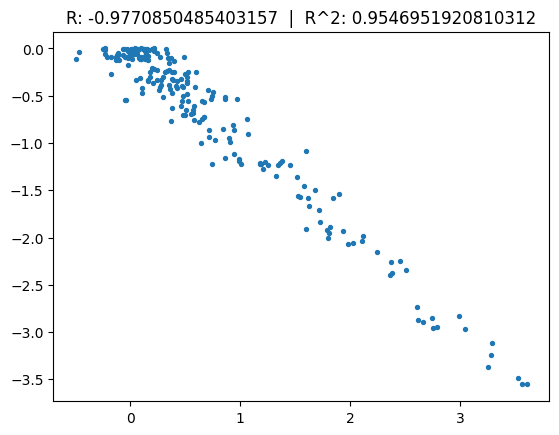

In [67]:
plt.scatter(lookup_training_task["y"], lookup_test_task["y"], 8);
slope, intercept, r_value, p_value, std_err = stats.linregress(lookup_training_task["y"], lookup_test_task["y"])
plt.title(f"R: {r_value}  |  R^2: {r_value**2}");

In [57]:
base_scenario = {'Baseline': Campaign(searchspace=searchspace, objective=objective)}
scenarios = {}
initial_datas = {}
n_init_data_for_tl_list = [10, 20, 50, 100]

for n_init_data_for_tl in n_init_data_for_tl_list:
    campaign_tl = Campaign(searchspace=searchspace, objective=objective)
    scenarios[f"TL_{n_init_data_for_tl}"] = campaign_tl
    initial_datas[f"TL_{n_init_data_for_tl}"] = []
    
    for _ in range(N_MC_ITERATIONS):    
        # Generate training data points for the source task
        x_init = np.random.uniform(-bound_scale, bound_scale, (n_init_data_for_tl, DIMENSION))
        y_init = test_functions["Source"](*x_init)

        df_init = pd.DataFrame(x_init, columns=[f"x{d}" for d in range(DIMENSION)])
        df_init["Function"] = "Source"
        df_init["Target"] = y_init
        
        initial_datas[f"TL_{n_init_data_for_tl}"].append(df_init)

NameError: name 'bound_scale' is not defined

# Run Backtest

In [68]:
import warnings
warnings.filterwarnings("ignore")

results: list[pd.DataFrame] = []
for p in (0.01, 0.02, 0.05, 0.1, 0.2):
    campaign = Campaign(searchspace=searchspace, objective=objective)
    initial_data = [lookup_training_task.sample(frac=p) for _ in range(N_MC_ITERATIONS)]
    result_fraction = simulate_scenarios(
        {f"{int(100*p)}": campaign},
        lookup_test_task,
        initial_data=initial_data,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
    )
    results.append(result_fraction)

result_baseline = simulate_scenarios(
    {"0": Campaign(searchspace=searchspace, objective=objective)},
    lookup_test_task,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)
results = pd.concat([result_baseline, *results])

100%|#############################################################################################################################################################################| 50/50 [00:54<00:00,  1.09s/it]


# Visualize Results

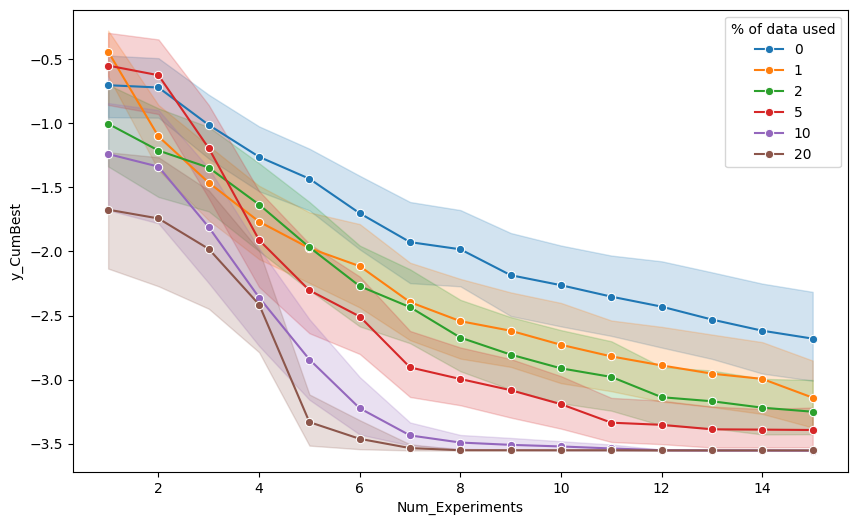

In [70]:
results.rename(columns={"Scenario": "% of data used"}, inplace=True)

path = Path(sys.path[0])
ax = sns.lineplot(
    data=results,
    marker="o",
    markersize=6,
    x="Num_Experiments",
    y="y_CumBest",
    hue="% of data used",
)

plt.gcf().set_size_inches((10,6))
plt.show()

# create_example_plots(
#     ax=ax,
#     path=path,
#     base_name="basic_transfer_learning",
# )